# Plot PCA of Paper

In [11]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-a-16-73.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 32
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [47]:
def remove_individuals(df, remove_list=["_d"], iid_col="iid"):
    """Remove indivdiuals from PCA dataframe"""
    idx = df[iid_col].str.contains("|".join(remove_list))
    df = df[~idx].copy()
    print(f"Filtering to {len(df)}/{len(idx)}")
    return df

def get_sub_iid(df, pop_list=[""], iid_col="iid", output=True):
    """Remove indivdiuals from PCA dataframe"""
    pops = "|".join(pop_list)
    idx = df[iid_col].str.contains(pops)
    df = df[idx].copy()
    if output:
        print(f"{pops} IIDs: {len(df)}/{len(idx)}")
    return df

def get_sub_pops(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    pops = "|".join(pop_list)
    idx = df[pop_col].str.contains(pops)
    df = df[idx].copy()
    print(f"{pops} Found: {len(df)}/{len(idx)}")
    return df

def get_sub_pops_exact(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    idx = df[pop_col].isin(pop_list)
    df = df[idx].copy()
    print(f"Found {pop_list} (exact): {len(df)}/{len(idx)}")
    return df

def split_up_df(df, col="loc"):
    """Split up Dataframe by column.
    Return column labels and dataframes"""
    locs = [l for l, _ in df.groupby(col)]
    dfs = [df for _, df in df.groupby(col)]
    return locs, dfs

####################################################
### Plotting PCA

def plot_pca(ax, df, c="", alpha=1.0, legend="", marker="o",
             s=30, ec=None, text=False, lw=1):
    """Plot PCA onto Axis"""
    if len(c)==0:
        c = df["color"].values
    a = ax.scatter(-df["pc1"], df["pc2"], c=c, alpha=alpha, label=legend, 
               ec=ec, s=s, marker=marker, lw=lw)
    if text:
        x, y = -df["pc1"].values, df["pc2"].values
        for i, txt in enumerate(df["iid"]):
            ax.annotate(txt, (x[i], y[i]), ha="left", va="bottom", c=c)
    return a
            
def plot_pca_ho(ax, df, c="gray", alpha=1.0, legend="", marker="o",
                s=30, ec=None, text=False):
    """Plot PCA onto Axis"""
    a = ax.scatter(-df["pc1"], df["pc2"], c=c, alpha=alpha, label=legend, 
               ec=ec, s=s, marker=marker)
    if text:
        x, y = -df["pc1"].values, df["pc2"].values
        for i, txt in enumerate(df["iid"]):
            ax.annotate(txt[:3], (x[i], y[i]), ha="center", va="center")   
    return a
            
###########################################################
### Helper Functions

def return_pca_matches(df, iid="I22119",
                       pcs = ["pc1", "pc2", "pc3", "pc4"]):
    """Return matches in pc space to sample iid.
    Report sorted dataframe"""
    pc_t = df[df["iid"]==iid][pcs]
    diffs = df[pcs]-pc_t.values
    diff_sq = np.sum(diffs**2,axis=1)
    idx = diff_sq.sort_values().index
    return df.iloc[idx,:].copy()

In [48]:
min_snp = 20000
#path_pca = "./output/pca/v49.2/20210809.punic.v49.2_HO.construct_WE_NA_PCA.smYES.outitY.evec.txt"
path_pca = "./output/pca/v51.1/20220317.punic.v51.1_HO.construct_WE_NA_PCA.smYES.outitY.evec.txt"
#path_meta = "/n/groups/reich/hringbauer/Data/v49.2.anno.csv"
path_meta = "/n/groups/reich/hringbauer/Data/v51.1.anno.csv"

df = pd.read_csv(path_pca, 
                 sep=r"\s+", skiprows=1, header=None)
df.columns=["iid", "pc1", "pc2", "pc3", "pc4", "pop"]
dfa = df.copy()   # A Deep Copy
df = remove_individuals(df, remove_list=["_d"])

df_meta = pd.read_csv(path_meta, sep=",")
df2 = df_meta[["iid", "Master ID", "clst", "loc", "n_cov_snp", 
               "mean_cov", "sex", "age", "contact", "lat", "lon"]]
df = pd.merge(df, df2, on="iid", how="left")


df["clst"].fillna(inplace = True, value="missing") # Fill NaNs

idx = (df["n_cov_snp"]<min_snp)
df = df[~idx]
df.loc[df["loc"].isnull(), "loc"]="not assigned"
print(f"Filtered to {len(df)} Individuals based on Min SNP: {min_snp}")

df = df.sort_values(by="n_cov_snp", ascending=False)
dup = (df["Master ID"].duplicated() & ~df["Master ID"].isnull())
df = df[~dup].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on duplicates")

idx = df["iid"]=="I22257" # The Sudan Outlier
df=df[~idx].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on manual removals")
#df[df["pop"].str.contains("Lebanon")]

Filtering to 2457/2494
Filtered to 2407 Individuals based on Min SNP: 20000
Filtered to 2314 based on duplicates
Filtered to 2313 based on manual removals


# Prepare the Populations to project

In [49]:
df_ho = get_sub_pops_exact(df, pop_list=["construct_WE_NA_PCA"])
df_is = get_sub_pops_exact(df, pop_list=["Israel_MLBA"])
df_le = get_sub_pops_exact(df, pop_list=["Lebanon_MBA.SG"])
#df_isp = get_sub_pops_exact(df, pop_list=["Israel_Phoenician"])
df_isp = get_sub_pops(df, pop_list=["Israel_Phoenician"], pop_col="clst")

df_sard = get_sub_pops(df, pop_list=["Italy_Sardinia_Punic"])
df_sard_ba = get_sub_pops_exact(df, pop_list=["Italy_Sardinia_EBA","Italy_Sardinia_BA_Nuragic"])

df_tun = get_sub_pops(df, pop_list=["Tunisia_N", "Tunisia_Mesolithic", "Tunisia_LN"], pop_col="clst")
df_gua = get_sub_pops(df, pop_list=["Guanche"])

df_vil = get_sub_iid(df, ["VIL"])
df_msr = get_sub_iid(df, ["MSR"])

df_greek = get_sub_pops_exact(df, pop_list=["Greece_BA_Mycenaean"])
df_alg = get_sub_pops(df, pop_list=["Algeria_IA"], pop_col="clst")
df_spain = get_sub_pops_exact(df, pop_list=["Spain_IA", "Spain_IA_Tartessian", "Spain_IA_Celt", "Spain_IA_Celt.SG"])

df_sic_mba = get_sub_pops_exact(df, pop_list=["Italy_Sicily_MBA"], pop_col="clst")

df_vill = get_sub_pops(df, pop_list=["Villaricos"], pop_col="loc")
df_vill = df_vill[(df_vill["pop"].str.contains("Punic")) & (df_vill["age"]>2000)]
df_ib = get_sub_pops(df, ["Ibiza_Punic"])
#df_sic = get_sub_pops_exact(df, ["Italy_Phoenician_Sicily"])
df_sic2 = get_sub_pops(df, ["Italy_Sicily_Punic"])
df_mar = df_sic2[df_sic2["loc"].str.contains("Marsala")].copy()
df_mot = df_sic2[df_sic2["loc"].str.contains("Motya")].copy()
df_bir = df_sic2[df_sic2["loc"].str.contains("Birgi")].copy()
df_sel = df_sic2[df_sic2["loc"].str.contains("Selinunte")].copy()
df_pal = df_sic2[df_sic2["loc"].str.contains("Palermo")].copy()

dft = get_sub_pops(df, ["Spain_Punic"])
df_cad = get_sub_pops(df, pop_list=["Cádiz"], pop_col="loc")

df_sic_ia = get_sub_pops_exact(df, ["Italy_Sicily_IA_Polizzello"])
df_sic_him = get_sub_pops(df, ["Sicily_Himera"])

df_eg_hell = get_sub_pops(df, ["Egypt_Hellenistic"])
df_eg_dyn = get_sub_pops(df, ["Egypt_Dynastic"])
df_meno = get_sub_pops(df, ["Menorca"])
df_kerk = get_sub_pops_exact(df, ["Kerkouene"], pop_col="loc")



#### Update Colors
df_is["color"]="#33A8C7"
df_greek["color"]="#52E3E1"
df_spain["color"]="gray"
df_sard_ba["color"]="#A0E426"
df_sic_ia["color"]="green"
df_sic_mba["color"]="olive"
df_tun["color"]="#F050AE"
df_gua["color"]="#D883FF"
df_meno["color"]="lightgray"
df_eg_hell["color"]="#F77976"
df_alg["color"] = "#343a40"


df_is["label"]="Canaanite MLBA"
df_greek["label"]="Mycenean BA"
df_spain["label"]="Iberia IA"
df_sard_ba["label"]="Sardinia BA"
df_sic_ia["label"]="Sicily Polizzello IA"
df_sic_mba["label"]="Sicily Motya MBA"
df_tun["label"]="Tunisia M/N"
df_gua["label"]="Guanche Pre-Contact"
df_meno["label"]= "Menorca LBA"
df_eg_hell["label"]="Egypt Hellenistic"
df_alg["label"]="Algeria IA"

df_save = pd.concat((df_is, df_greek, df_spain, df_sard_ba, df_sic_ia,
               df_sic_mba, df_tun, df_gua, df_meno, df_eg_hell, df_alg))

savepath = "./output/tables/reference_samples_plot.v51.1.tsv"
df_save.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(df_save)} reference Samples to: {savepath}")

Found ['construct_WE_NA_PCA'] (exact): 1187/2313
Found ['Israel_MLBA'] (exact): 35/2313
Found ['Lebanon_MBA.SG'] (exact): 5/2313
Israel_Phoenician Found: 13/2313
Italy_Sardinia_Punic Found: 1/2313
Found ['Italy_Sardinia_EBA', 'Italy_Sardinia_BA_Nuragic'] (exact): 23/2313
Tunisia_N|Tunisia_Mesolithic|Tunisia_LN Found: 7/2313
Guanche Found: 5/2313
VIL IIDs: 6/2313
MSR IIDs: 2/2313
Found ['Greece_BA_Mycenaean'] (exact): 12/2313
Algeria_IA Found: 1/2313
Found ['Spain_IA', 'Spain_IA_Tartessian', 'Spain_IA_Celt', 'Spain_IA_Celt.SG'] (exact): 22/2313
Found ['Italy_Sicily_MBA'] (exact): 4/2313
Villaricos Found: 16/2313
Ibiza_Punic Found: 1/2313
Italy_Sicily_Punic Found: 0/2313
Spain_Punic Found: 3/2313
Cádiz Found: 4/2313
Found ['Italy_Sicily_IA_Polizzello'] (exact): 19/2313
Sicily_Himera Found: 30/2313
Egypt_Hellenistic Found: 3/2313
Egypt_Dynastic Found: 2/2313
Menorca Found: 5/2313
Found ['Kerkouene'] (exact): 27/2313
Saved 136 reference Samples to: ./output/tables/reference_samples_plot.v5

In [ ]:
df_kerk

### Save the Plots for PCA

In [11]:
df[df["iid"].str.contains("I20824")]

,iid,pc1,pc2,pc3,pc4,pop,Master ID,loc,n_cov_snp,mean_cov,sex,age,contact,lat,lon
529,I20824,-0.055073,-0.055335,-0.061695,-0.075166,include,I20824,Djebba,477650.0,0.398042,F,8103.0,"Pinhasi, Ron",36.490556,9.092222


# Panels for the PCA

## Context

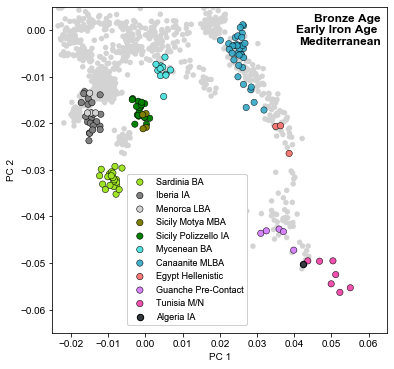

In [30]:
#savepath="./figures/pca.49.2b/context.pdf"
savepath=""

plt.figure(figsize=(6,6))
ax = plt.gca()

### Plot Context
lw=0.5
ec="k"
s=40

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
l1 = plot_pca(ax, df_is, legend="", ec=ec, alpha=0.9, s=40, lw=lw)
l2 = plot_pca(ax, df_greek, legend="", ec=ec, s=s, lw=lw)
l3 = plot_pca(ax, df_spain, legend="", s=s, ec=ec, lw=lw)
l4 = plot_pca(ax, df_sard_ba, legend="", ec=ec, s=s, lw=lw)
l5 = plot_pca(ax, df_sic_ia, legend="", s=s, ec=ec, lw=lw)
l6 = plot_pca(ax, df_sic_mba, legend="", s=s, ec=ec, lw=lw)
l7 = plot_pca(ax, df_tun, legend="", ec=ec, s=s, lw=lw)
l8 = plot_pca(ax, df_gua, legend="", s=s, ec=ec, lw=lw)
l9 = plot_pca(ax, df_meno, legend="", s=s, ec=ec, lw=lw)
l10 = plot_pca(ax, df_eg_hell, legend="", s=s, ec=ec, lw=lw)

df_iid = get_sub_iid(df, ["I12433"], output=False)
a9 = plot_pca(ax, df_iid, c="#343a40",
         legend="", ec="k", s=s, marker="o")

labels = ["Sardinia BA", "Iberia IA", "Menorca LBA", "Sicily Motya MBA", "Sicily Polizzello IA", 
          "Mycenean BA", "Canaanite MLBA", "Egypt Hellenistic", "Guanche Pre-Contact",
          "Tunisia M/N", "Algeria IA"]

plots = [l4, l3, l9, l6, l5, l2, l1, l10, l8, l7, a9]
leg1 = ax.legend(plots, labels, fontsize=9,
          bbox_to_anchor=(0.21, 0.01), loc="lower left")

ax.add_artist(leg1)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.065])
ax.set_ylim([-0.065,0.005])

### Title left top:
ax.text(0.98, 0.98, "Bronze Age\nEarly Iron Age \nMediterranean", weight='bold',
        ha="right", va="top", fontsize=12, transform = ax.transAxes, zorder=20)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

## Early Punic 800-400 calBCE

Saved to: ./figures/pca.v51.1/early_punic.pdf


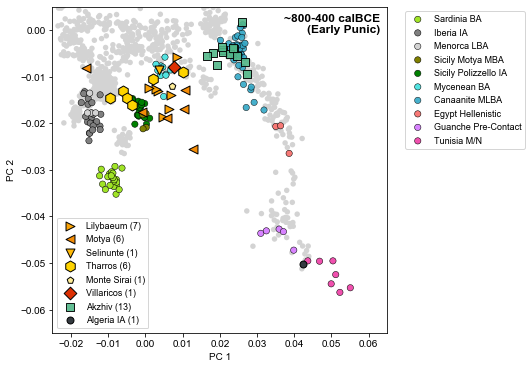

In [52]:
savepath="./figures/pca.v51.1/early_punic.pdf"

plt.figure(figsize=(6,6))
ax = plt.gca()

### Plot Context
lw=0.5
ec="k"
s=40

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
l1 = plot_pca(ax, df_is, legend="", ec=ec, alpha=0.9, s=40, lw=lw)
l2 = plot_pca(ax, df_greek, legend="", ec=ec, s=s, lw=lw)
l3 = plot_pca(ax, df_spain, legend="", s=s, ec=ec, lw=lw)
l4 = plot_pca(ax, df_sard_ba, legend="", ec=ec, s=s, lw=lw)
l5 = plot_pca(ax, df_sic_ia, legend="", s=s, ec=ec, lw=lw)
l6 = plot_pca(ax, df_sic_mba, legend="", s=s, ec=ec, lw=lw)
l7 = plot_pca(ax, df_tun, legend="", ec=ec, s=s, lw=lw)
l8 = plot_pca(ax, df_gua, legend="", s=s, ec=ec, lw=lw)
l9 = plot_pca(ax, df_meno, legend="", s=s, ec=ec, lw=lw)
l10 = plot_pca(ax, df_eg_hell, legend="", s=s, ec=ec, lw=lw)

labels = ["Sardinia BA", "Iberia IA", "Menorca LBA", "Sicily Motya MBA", "Sicily Polizzello IA", 
          "Mycenean BA", "Canaanite MLBA", "Egypt Hellenistic", "Guanche Pre-Contact",
          "Tunisia M/N"]

plots = [l4, l3, l9, l6, l5, l2, l1, l10, l8, l7]
leg1 = ax.legend(plots, labels, fontsize=9,
          bbox_to_anchor=(1.04,1), loc="upper left")

### Plot the early Punic Samples
s=80

### Kamerina
#df_iid = get_sub_iid(df, ["I14915", "I19532"], output=False)
#a1 = plot_pca(ax, df_iid, c="turquoise", legend="", ec="k", s=s, marker="D")

# Lilibayem
df_iid = get_sub_iid(df, ["I12666","I12847","I24678|I24676|I24675|I24556|I22095"], output=False)
a2 = plot_pca(ax, df_iid, c="#FAA307", legend="", ec="k", s=s, marker=">")

### Motya
df_iid = get_sub_iid(df, ["I4798|I4799|I4800|I7762|I22236|I22232"], output=False)
a3 = plot_pca(ax, df_iid, c="#F48C06", legend="", ec="k", s=s, marker="<")

### Selinunte
df_iid = get_sub_iid(df, ["I21853"], output=False)
a4 = plot_pca(ax, df_iid, c="#FFBA08", legend="", ec="k", s=s, marker="v")


### Tharros
df_iid = get_sub_iid(df, ["I22115", "I22121", "I22096", 
                          "I22122", "I22118", "I22117"], output=False)
a5 = plot_pca(ax, df_iid, c="#ffd400", legend="", 
         ec="k", s=s*1.5, marker="h")

### Villaricos
df_iid = get_sub_iid(df, ["I18201"], output=False)
a6 = plot_pca(ax, df_iid, c="#DC2F02", 
         legend="", ec="k", s=s, marker="D")

### Akzhiv
a7 = plot_pca(ax, df_isp, c="#52b788", 
         legend="", ec=ec, alpha=0.9, s=s, marker="s")

### Monte Sirai
df_iid = get_sub_iid(df, ["MSR002"], output=False)
a8 = plot_pca(ax, df_iid, c="#ffee99",
         legend="", ec="k", s=s*0.6, marker="p")

### Algeria IA
df_iid = get_sub_iid(df, ["I12433"], output=False)
a9 = plot_pca(ax, df_iid, c="#343a40",
         legend="", ec="k", s=s*0.6, marker="o")



plots = [a2, a3, a4, a5, a8, a6, a7, a9]
legs = ["Lilybaeum (7)", "Motya (6)", "Selinunte (1)", "Tharros (6)",
        "Monte Sirai (1)", "Villaricos (1)", "Akzhiv (13)", "Algeria IA (1)"]

ax.legend(plots, legs, fontsize=9, loc="lower left",
         title="")

ax.add_artist(leg1)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.065])
ax.set_ylim([-0.065,0.005])

### Title left top:
ax.text(0.98, 0.98, "~800-400 calBCE\n(Early Punic)", weight='bold',
        ha="right", va="top", fontsize=12, transform = ax.transAxes, zorder=20)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

### Peak Punic [400-200 BCE]

Saved to: ./figures/pca.v51.1/late_punic.pdf


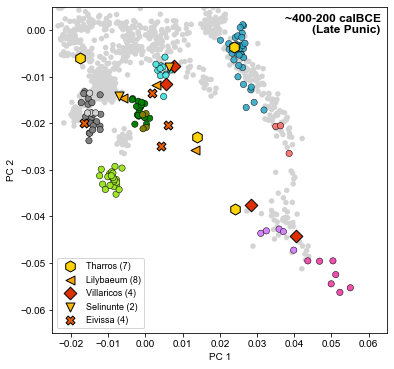

In [53]:
savepath="./figures/pca.v51.1/late_punic.pdf"

plt.figure(figsize=(6,6))
ax = plt.gca()

### Plot Context
lw=0.5
ec="k"
s=40

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
l1 = plot_pca(ax, df_is, legend="", ec=ec, alpha=0.9, s=40, lw=lw)
l2 = plot_pca(ax, df_greek, legend="", ec=ec, s=s, lw=lw)
l3 = plot_pca(ax, df_spain, legend="", s=s, ec=ec, lw=lw)
l4 = plot_pca(ax, df_sard_ba, legend="", ec=ec, s=s, lw=lw)
l5 = plot_pca(ax, df_sic_ia, legend="", s=s, ec=ec, lw=lw)
l6 = plot_pca(ax, df_sic_mba, legend="", s=s, ec=ec, lw=lw)
l7 = plot_pca(ax, df_tun, legend="", ec=ec, s=s, lw=lw)
l8 = plot_pca(ax, df_gua, legend="", s=s, ec=ec, lw=lw)
l9 = plot_pca(ax, df_meno, legend="", s=s, ec=ec, lw=lw)
l10 = plot_pca(ax, df_eg_hell, legend="", s=s, ec=ec, lw=lw)

### Plot the early Punic Samples
s=80

### Tharros
df_iid = get_sub_iid(df, ["I22114", "I22119", "I21966", "I22093"], output=False) # 400-200 calBCE
a1 = plot_pca(ax, df_iid, c="#ffd400", legend="Tharros 400-200 calBCE (4)", 
         ec="k", s=s*1.5, marker="h")

### Lilybaeum
df_iid = get_sub_iid(df, ["I24555", "I12848", "I21857"], output=False)
a2 = plot_pca(ax, df_iid, c="#FAA307", legend="Lilybaeum 400-200 calBCE (3)", 
              ec="k", s=s, marker="<")

### Villaricos
df_iid = get_sub_iid(df, ["I18193", "I18189", "I18199", "I18203"], output=False)
a3 = plot_pca(ax, df_iid, c="#DC2F02", legend="Villaricos 400-200 calBCE (4)", 
              ec="k", s=s, marker="D")

### Selinunt
df_iid = get_sub_iid(df, ["I21197", "I21855"], output=False)
a4 = plot_pca(ax, df_iid, c="#FFBA08", legend="Selinunte 400-200 calBCE (2)", 
              ec="k", s=s, marker="v")


### Eivissa
df_iid = get_sub_iid(df, ["I27602", "I27619", "I27618", "I27613"], output=False)
a5 = plot_pca(ax, df_iid, c="#E85D04", legend="Eivissa", 
              ec="k", s=80, marker="X")

# Legend for time
#plots = [a1, b1]
#legs = ["400-200 calBCE", "350-50 calBCE"]
#leg1 = ax.legend(plots, legs, fontsize=9,  
#                 bbox_to_anchor=(0.68, 0.86), loc="upper left", title="")

plots = [a1, a2, a3, a4, a5]
legs = ["Tharros (7)", "Lilybaeum (8)",
        "Villaricos (4)", "Selinunte (2)", "Eivissa (4)"]

ax.legend(plots, legs, fontsize=9, loc="lower left",
         title="")
#ax.add_artist(leg1)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.065])
ax.set_ylim([-0.065,0.005])

### Title left top:
ax.text(0.98, 0.98, "~400-200 calBCE\n(Late Punic)", weight='bold',
        ha="right", va="top", fontsize=12, transform = ax.transAxes, zorder=20)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

### Late Punic / Early Roman

Saved to: ./figures/pca.49.2b/late_punic_roman.pdf


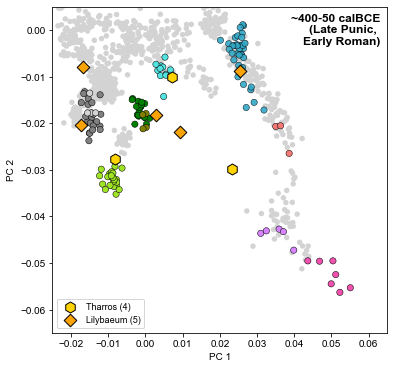

In [54]:
savepath="./figures/pca.49.2b/late_punic_roman.pdf"

plt.figure(figsize=(6,6))
ax = plt.gca()

### Plot Context
lw=0.5
ec="k"
s=40

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
l1 = plot_pca(ax, df_is, legend="", ec=ec, alpha=0.9, s=40, lw=lw)
l2 = plot_pca(ax, df_greek, legend="", ec=ec, s=s, lw=lw)
l3 = plot_pca(ax, df_spain, legend="", s=s, ec=ec, lw=lw)
l4 = plot_pca(ax, df_sard_ba, legend="", ec=ec, s=s, lw=lw)
l5 = plot_pca(ax, df_sic_ia, legend="", s=s, ec=ec, lw=lw)
l6 = plot_pca(ax, df_sic_mba, legend="", s=s, ec=ec, lw=lw)
l7 = plot_pca(ax, df_tun, legend="", ec=ec, s=s, lw=lw)
l8 = plot_pca(ax, df_gua, legend="", s=s, ec=ec, lw=lw)
l9 = plot_pca(ax, df_meno, legend="", s=s, ec=ec, lw=lw)
l10 = plot_pca(ax, df_eg_hell, legend="", s=s, ec=ec, lw=lw)

### Plot the early Punic Samples
s=80

### Tharros
df_iid = get_sub_iid(df, ["I22113", "I22125", "I22088"], output=False) # 400-200 calBCE
b1 = plot_pca(ax, df_iid, c="#ffd400", legend="Tharros 350-50 calBCE (3)", 
         ec="k", s=s*1.5, marker="h")

### Lilybaeum
df_iid = get_sub_iid(df, ["I12665", "I21859", "I12846", "I8577", "I7454"], output=False)
b2 = plot_pca(ax, df_iid, c="#FAA307", legend="Lilybaeum 350-50 calBCE (5)", 
              ec="k", s=80, marker="D")



#plots = [a1, b1]
#legs = ["400-200 calBCE", "350-50 calBCE"]
#leg1 = ax.legend(plots, legs, fontsize=9,  
#                 bbox_to_anchor=(0.68, 0.86), loc="upper left", title="")

plots = [b1, b2]
legs = ["Tharros (4)", "Lilybaeum (5)"]

ax.legend(plots, legs, fontsize=9, loc="lower left", title="")
#ax.add_artist(leg1)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.065])
ax.set_ylim([-0.065,0.005])

### Title left top:
ax.text(0.98, 0.98, "~400-50 calBCE\n(Late Punic, \nEarly Roman)", 
        weight='bold',
        ha="right", va="top", fontsize=12, transform = ax.transAxes, zorder=20)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

### Roman times

Saved to: ./figures/pca.v49.2/roman.pdf


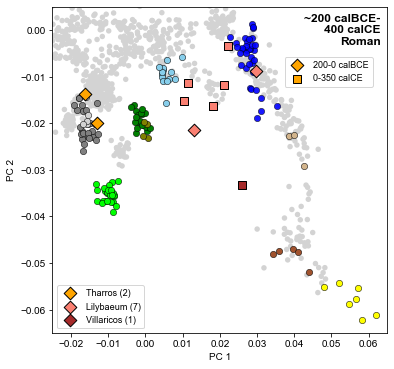

In [43]:
#savepath="./figures/pca.v49.2/late_punic.pdf"
savepath="./figures/pca.49.2b/roman.pdf"

plt.figure(figsize=(6,6))
ax = plt.gca()

### Plot Context
lw=0.5
ec="k"
s=40

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
l1 = plot_pca(ax, df_is, c="blue", legend="", ec=ec, alpha=0.9, s=40, lw=lw)
l2 = plot_pca(ax, df_greek, c="skyblue", legend="", ec=ec, s=s, lw=lw)
l3 = plot_pca(ax, df_spain, c="gray", legend="", s=s, ec=ec, lw=lw)
l4 = plot_pca(ax, df_sard_ba, c="lime", legend="", ec=ec, s=s, lw=lw)
l5 = plot_pca(ax, df_sic_ia, c="green", legend="", s=s, ec=ec, lw=lw)
l6 = plot_pca(ax, df_sic_mba, c="olive", legend="", s=s, ec=ec, lw=lw)
l7 = plot_pca(ax, df_tun, c="yellow", legend="", ec=ec, s=s, lw=lw)
l8 = plot_pca(ax, df_gua, c="sienna", legend="", s=s, ec=ec, lw=lw)
l9 = plot_pca(ax, df_meno, c="lightgray", legend="", s=s, ec=ec, lw=lw)
l10 = plot_pca(ax, df_eg_hell, c="tan", legend="", s=s, ec=ec, lw=lw)

### Plot the early Punic Samples
s=80

### Tharros
df_iid = get_sub_iid(df, ["I21964", "I22112"], output=False) # 400-200 calBCE
a1 = plot_pca(ax, df_iid, c="#ffd400", legend="Tharros 200-0 calBCE (4)", 
         ec="k", s=s, marker="D")
df_iid = get_sub_iid(df, ["I22091"], output=False) # 400-200 calBCE
b1 = plot_pca(ax, df_iid, c="orange", legend="Tharros 0-350 calCE (4)", 
         ec="k", s=s, marker="s")

### Lilybaeum
df_iid = get_sub_iid(df, ["I12844", "I24554"], output=False)
a2 = plot_pca(ax, df_iid, c="salmon", legend="Lilybaeum 200-0 calBCE (2)", 
              ec="k", s=s, marker="D")

df_iid = get_sub_iid(df, ["I12664", "I12849", "I7265", 
                          "I21970", "I24680", "I24557"], output=False)
b2 = plot_pca(ax, df_iid, c="salmon", legend="Lilybaeum 0-400 calCE (5)", 
              ec="k", s=s, marker="s")

### Villaricos
#df_iid = get_sub_iid(df, ["XXXXXXXX"], output=False)
#a3 = plot_pca(ax, df_iid, c="brown", legend="Villaricos 200-0 calBCE  (0))", 
#              ec="k", s=s, marker="D")

df_iid = get_sub_iid(df, ["I18198", "I18400"], output=False)
b3 = plot_pca(ax, df_iid, c="brown", legend="Villaricos 0-400 calCE (2))", 
              ec="k", s=80, marker="s")

plots = [a1, b1]
legs = ["200-0 calBCE", "0-350 calCE"]
leg1 = ax.legend(plots, legs, fontsize=9,  
                 bbox_to_anchor=(0.68, 0.86), loc="upper left", title="")

plots = [a1, a2, a3, a4]
legs = ["Tharros (2)", "Lilybaeum (7)", "Villaricos (1)"]

ax.legend(plots, legs, fontsize=9, loc="lower left", title="")
ax.add_artist(leg1)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.065])
ax.set_ylim([-0.065,0.005])

### Title left top:
ax.text(0.98, 0.98, "~200 calBCE-\n400 calCE\nRoman", 
        weight='bold',  ha="right", va="top", fontsize=12, transform = ax.transAxes, zorder=20)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

df_t

# Kerkouane Family

Saved to: ./figures/pca.v51.1/kerkouene.pdf


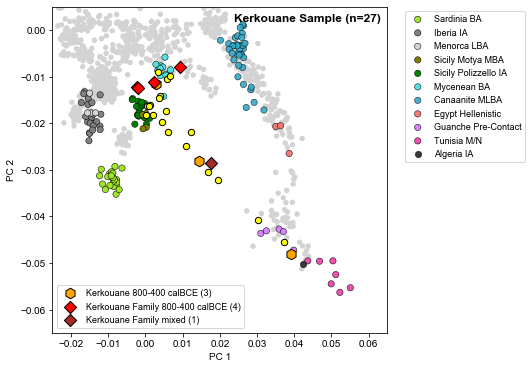

In [70]:
savepath="./figures/pca.v51.1/kerkouene.pdf"

plt.figure(figsize=(6,6))
ax = plt.gca()

### Plot Context
lw=0.5
ec="k"
s=40

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
l1 = plot_pca(ax, df_is, legend="", ec=ec, alpha=0.9, s=40, lw=lw)
l2 = plot_pca(ax, df_greek, legend="", ec=ec, s=s, lw=lw)
l3 = plot_pca(ax, df_spain, legend="", s=s, ec=ec, lw=lw)
l4 = plot_pca(ax, df_sard_ba, legend="", ec=ec, s=s, lw=lw)
l5 = plot_pca(ax, df_sic_ia, legend="", s=s, ec=ec, lw=lw)
l6 = plot_pca(ax, df_sic_mba, legend="", s=s, ec=ec, lw=lw)
l7 = plot_pca(ax, df_tun, legend="", ec=ec, s=s, lw=lw)
l8 = plot_pca(ax, df_gua, legend="", s=s, ec=ec, lw=lw)
l9 = plot_pca(ax, df_meno, legend="", s=s, ec=ec, lw=lw)
l10 = plot_pca(ax, df_eg_hell, legend="", s=s, ec=ec, lw=lw)
l11 = plot_pca(ax, df_alg, legend="", s=s, ec=ec, lw=lw)

### Kerkouane Background
b1 = plot_pca(ax, df_kerk, c="yellow", legend="Kerkouane all", 
              ec="k", s=40, marker="o")



### Kerkouane General
df_iid = get_sub_iid(df, ["I24041", "I24036", "I24031"], output=False) # 400-200 calBCE
a1 = plot_pca(ax, df_iid, c="orange", legend="Kerkouane 800-400 calBCE (3)", 
         ec="k", s=110, marker="h")

### Kerkouane Family
df_iid = get_sub_iid(df, ["I24494", "I24040", "I24194",  "I24193"], output=False)# 
a2 = plot_pca(ax, df_iid, c="red", legend="Kerkouane Family 800-400 calBCE (4)", 
              ec="k", s=75, marker="D")


### Kerkouane Family Outlier
df_iid = get_sub_iid(df, ["I24215"], output=False)
a3 = plot_pca(ax, df_iid, c="brown", legend="Kerkouane Family mixed", 
              ec="k", s=75, marker="D")


labels = ["Sardinia BA", "Iberia IA", "Menorca LBA", "Sicily Motya MBA", "Sicily Polizzello IA", 
          "Mycenean BA", "Canaanite MLBA", "Egypt Hellenistic", "Guanche Pre-Contact",
          "Tunisia M/N", "Algeria IA"]

plots = [l4, l3, l9, l6, l5, l2, l1, l10, l8, l7, l11]
leg1 = ax.legend(plots, labels, fontsize=9,
          bbox_to_anchor=(1.04,1), loc="upper left")


plots = [a1, a2, a3]
legs = ["Kerkouane 800-400 calBCE (3)", "Kerkouane Family 800-400 calBCE (4)", "Kerkouane Family mixed (1)"]

leg = ax.legend(plots, legs, fontsize=9, loc="lower left", title="")
#ax.add_artist(leg1)


ax.add_artist(leg1)



ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.065])
ax.set_ylim([-0.065,0.005])

### Title left top:
ax.text(0.98, 0.98, "Kerkouane Sample (n=27)", 
        weight='bold',
        ha="right", va="top", fontsize=12, transform = ax.transAxes, zorder=20)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

# Supplement Figures: Other sites

In [ ]:
plot_pca_sample(iid=["I24041", "I24036", "I24031"], savepath="", label="Kerkouane 800-400 calBCE") 

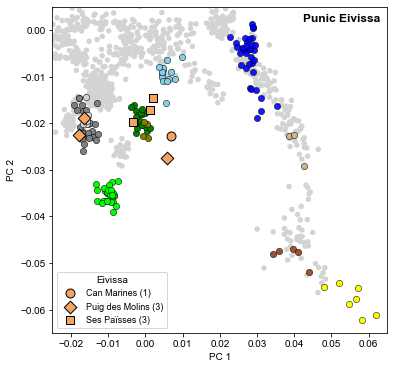

In [5]:
#savepath="./figures/pca.v49.2/late_punic.pdf"
savepath=""

plt.figure(figsize=(6,6))
ax = plt.gca()

### Plot Context
lw=0.5
ec="k"
s=40

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
l1 = plot_pca(ax, df_is, c="blue", legend="", ec=ec, alpha=0.9, s=40, lw=lw)
l2 = plot_pca(ax, df_greek, c="skyblue", legend="", ec=ec, s=s, lw=lw)
l3 = plot_pca(ax, df_spain, c="gray", legend="", s=s, ec=ec, lw=lw)
l4 = plot_pca(ax, df_sard_ba, c="lime", legend="", ec=ec, s=s, lw=lw)
l5 = plot_pca(ax, df_sic_ia, c="green", legend="", s=s, ec=ec, lw=lw)
l6 = plot_pca(ax, df_sic_mba, c="olive", legend="", s=s, ec=ec, lw=lw)
l7 = plot_pca(ax, df_tun, c="yellow", legend="", ec=ec, s=s, lw=lw)
l8 = plot_pca(ax, df_gua, c="sienna", legend="", s=s, ec=ec, lw=lw)
l9 = plot_pca(ax, df_meno, c="lightgray", legend="", s=s, ec=ec, lw=lw)
l10 = plot_pca(ax, df_eg_hell, c="tan", legend="", s=s, ec=ec, lw=lw)

### Plot the early Punic Samples
s=80

### Tharros
df_iid = get_sub_iid(df, ["I27602"], output=False) # 400-200 calBCE
a1 = plot_pca(ax, df_iid, c="sandybrown", legend="Can Marines", 
         ec="k", s=s, marker="o")

df_iid = get_sub_iid(df, ["I27618", "I27619", "I27620"], output=False) # 400-200 calBCE
a2 = plot_pca(ax, df_iid, c="sandybrown", legend="Puig des Molins", 
         ec="k", s=s, marker="D")

df_iid = get_sub_iid(df, ["I27610", "I27614", "I27613"], output=False) # 400-200 calBCE
a3 = plot_pca(ax, df_iid, c="sandybrown", legend="Ses Païsses", 
         ec="k", s=s, marker="s")

plots = [a1, a2, a3]
legs = ["Can Marines (1)", "Puig des Molins (3)", "Ses Païsses (3)"]

ax.legend(plots, legs, fontsize=9, loc="lower left", title="Eivissa")


#ax.legend(plots, legs, fontsize=9, loc="lower left", title="")
#ax.add_artist(leg1)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.065])
ax.set_ylim([-0.065,0.005])

### Title left top:
ax.text(0.98, 0.98, "Punic Eivissa", 
        weight='bold',  ha="right", va="top", fontsize=12, transform = ax.transAxes, zorder=20)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

### T774 Cluster

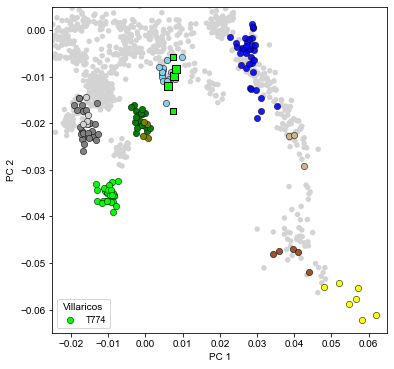

In [17]:
#savepath="./figures/pca.v49.2/late_punic.pdf"
savepath=""

plt.figure(figsize=(6,6))
ax = plt.gca()

### Plot Context
lw=0.5
ec="k"
s=40

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
l1 = plot_pca(ax, df_is, c="blue", legend="", ec=ec, alpha=0.9, s=40, lw=lw)
l2 = plot_pca(ax, df_greek, c="skyblue", legend="", ec=ec, s=s, lw=lw)
l3 = plot_pca(ax, df_spain, c="gray", legend="", s=s, ec=ec, lw=lw)
l4 = plot_pca(ax, df_sard_ba, c="lime", legend="", ec=ec, s=s, lw=lw)
l5 = plot_pca(ax, df_sic_ia, c="green", legend="", s=s, ec=ec, lw=lw)
l6 = plot_pca(ax, df_sic_mba, c="olive", legend="", s=s, ec=ec, lw=lw)
l7 = plot_pca(ax, df_tun, c="yellow", legend="", ec=ec, s=s, lw=lw)
l8 = plot_pca(ax, df_gua, c="sienna", legend="", s=s, ec=ec, lw=lw)
l9 = plot_pca(ax, df_meno, c="lightgray", legend="", s=s, ec=ec, lw=lw)
l10 = plot_pca(ax, df_eg_hell, c="tan", legend="", s=s, ec=ec, lw=lw)

### Plot the early Punic Samples
s=80

### Tharros
iids = ["I18199",  "I18201", "I18203"]

df_iid = get_sub_iid(df, iids, output=False) # 400-200 calBCE
a1 = plot_pca(ax, df_iid, c="lime", legend="", 
         ec="k", s=s, marker="s")

iids = ["I18200", "I18202"]
df_iid = get_sub_iid(df, iids, output=False) # 400-200 calBCE
a2 = plot_pca(ax, df_iid, c="lime", legend="", 
         ec="k", s=s/2, marker="s")

plots = [a1]
legs = ["T774"]

labels = ["Sardinia BA", "Iberia IA", "Menorca LBA", "Sicily Motya MBA", "Sicily Polizzello IA", 
          "Mycenean BA", "Canaanite MLBA", "Egypt Hellenistic", "Guanche Pre-Contact",
          "Tunisia M/N"]

plots = [l4, l3, l9, l6, l5, l2, l1, l10, l8, l7]
leg1 = ax.legend(plots, labels, fontsize=9,
          bbox_to_anchor=(0.21, 0.01), loc="lower left")

ax.legend(plots, legs, fontsize=9, loc="lower left", title="Villaricos")
#ax.legend(plots, legs, fontsize=9, loc="lower left", title="")
#ax.add_artist(leg1)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.065])
ax.set_ylim([-0.065,0.005])

### Title left top:
#ax.text(0.98, 0.98, "T774, Villaricos", 
#        weight='bold',  ha="right", va="top", fontsize=12, transform = ax.transAxes, zorder=20)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

### Individuals from Tharros

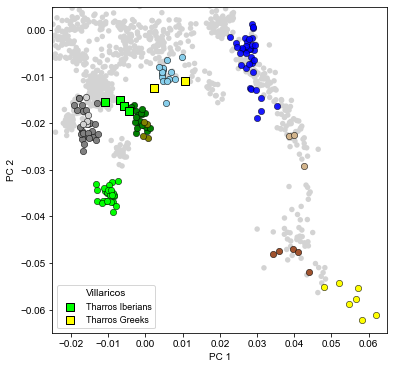

In [14]:
#savepath="./figures/pca.v49.2/late_punic.pdf"
savepath=""

plt.figure(figsize=(6,6))
ax = plt.gca()

### Plot Context
lw=0.5
ec="k"
s=40

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
l1 = plot_pca(ax, df_is, c="blue", legend="", ec=ec, alpha=0.9, s=40, lw=lw)
l2 = plot_pca(ax, df_greek, c="skyblue", legend="", ec=ec, s=s, lw=lw)
l3 = plot_pca(ax, df_spain, c="gray", legend="", s=s, ec=ec, lw=lw)
l4 = plot_pca(ax, df_sard_ba, c="lime", legend="", ec=ec, s=s, lw=lw)
l5 = plot_pca(ax, df_sic_ia, c="green", legend="", s=s, ec=ec, lw=lw)
l6 = plot_pca(ax, df_sic_mba, c="olive", legend="", s=s, ec=ec, lw=lw)
l7 = plot_pca(ax, df_tun, c="yellow", legend="", ec=ec, s=s, lw=lw)
l8 = plot_pca(ax, df_gua, c="sienna", legend="", s=s, ec=ec, lw=lw)
l9 = plot_pca(ax, df_meno, c="lightgray", legend="", s=s, ec=ec, lw=lw)
l10 = plot_pca(ax, df_eg_hell, c="tan", legend="", s=s, ec=ec, lw=lw)

### Plot the early Punic Samples
s=80

### Tharros
iids = ["I22115", "I22121", "I22118", "I22096"]
iids2 = ["I22122", "I22117"]

df_iid = get_sub_iid(df, iids, output=False) # 400-200 calBCE
df_iid2 = get_sub_iid(df, iids2, output=False) # 400-200 calBCE
a1 = plot_pca(ax, df_iid, c="lime", legend="", 
         ec="k", s=s, marker="s")

a2 = plot_pca(ax, df_iid2, c="yellow", legend="", 
         ec="k", s=s, marker="s")

plots = [a1, a2]
legs = ["Tharros Iberians", "Tharros Greeks"]

leg1 = ax.legend(plots, legs, fontsize=9,
          bbox_to_anchor=(0.21, 0.01), loc="lower left")

ax.legend(plots, legs, fontsize=9, loc="lower left", title="Villaricos")
#ax.legend(plots, legs, fontsize=9, loc="lower left", title="")
#ax.add_artist(leg1)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.065])
ax.set_ylim([-0.065,0.005])

### Title left top:
#ax.text(0.98, 0.98, "T774, Villaricos", 
#        weight='bold',  ha="right", va="top", fontsize=12, transform = ax.transAxes, zorder=20)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")

# Supplement

### Plot Akhziv PCA
Plot Indivdiuals from Akhziv, split up by qpAdm Results

Saved to: ./figures/pca.v49.2/akhziv/overall.pdf


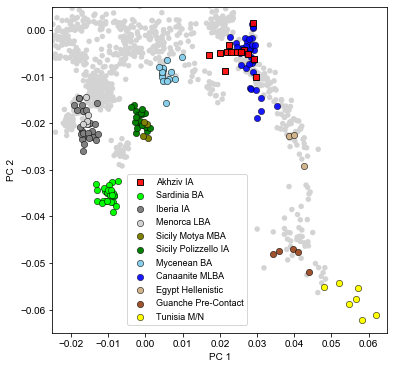

In [63]:
savepath="./figures/pca.v49.2/akhziv/overall.pdf"

plt.figure(figsize=(6,6))
ax = plt.gca()

### Plot Context
lw=0.5
ec="k"
s=40

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
l1 = plot_pca(ax, df_is, c="blue", legend="", ec=ec, alpha=0.9, s=40, lw=lw)
l2 = plot_pca(ax, df_greek, c="skyblue", legend="", ec=ec, s=s, lw=lw)
l3 = plot_pca(ax, df_spain, c="gray", legend="", s=s, ec=ec, lw=lw)
l4 = plot_pca(ax, df_sard_ba, c="lime", legend="", ec=ec, s=s, lw=lw)
l5 = plot_pca(ax, df_sic_ia, c="green", legend="", s=s, ec=ec, lw=lw)
l6 = plot_pca(ax, df_sic_mba, c="olive", legend="", s=s, ec=ec, lw=lw)
l7 = plot_pca(ax, df_tun, c="yellow", legend="", ec=ec, s=s, lw=lw)
l8 = plot_pca(ax, df_gua, c="sienna", legend="", s=s, ec=ec, lw=lw)
l9 = plot_pca(ax, df_meno, c="lightgray", legend="", s=s, ec=ec, lw=lw)
l10 = plot_pca(ax, df_eg_hell, c="tan", legend="", s=s, ec=ec, lw=lw)
l11 = plot_pca(ax, df_isp, c="red", 
         legend="", ec=ec, alpha=0.9, s=s, marker="s")

### Plot Yehud and Megiddo Split out

### Plot the early Punic Samples
s=70

#leg1 = ax.legend(plots, legs, fontsize=9,
#          bbox_to_anchor=(0.21, 0.01), loc="lower left")

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

ax.set_xlim([-0.025,0.065])
ax.set_ylim([-0.065,0.005])

ax.legend(plots, legs, fontsize=9, loc="lower left", title="")
#ax.legend(plots, legs, fontsize=9, loc="lower left", title="")
#ax.add_artist(leg1)

labels = ["Akhziv IA", "Sardinia BA", "Iberia IA", "Menorca LBA", "Sicily Motya MBA", "Sicily Polizzello IA", 
          "Mycenean BA", "Canaanite MLBA", "Egypt Hellenistic", "Guanche Pre-Contact",
          "Tunisia M/N"]

plots = [l11, l4, l3, l9, l6, l5, l2, l1, l10, l8, l7, leg1]
leg1 = ax.legend(plots, labels, fontsize=9,
          bbox_to_anchor=(0.21, 0.01), loc="lower left")

### Title left top:
#ax.text(0.98, 0.98, "T774, Villaricos", 
#        weight='bold',  ha="right", va="top", fontsize=12, transform = ax.transAxes, zorder=20)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")

Saved to: ./figures/pca.v49.2/akhziv/zoom.pdf


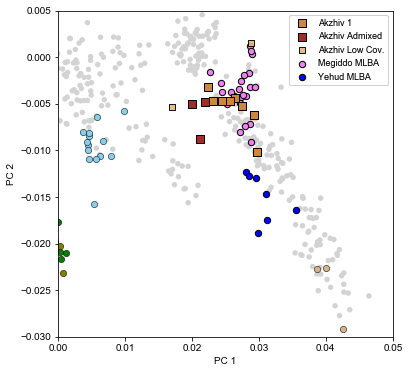

In [62]:
savepath = "./figures/pca.v49.2/akhziv/zoom.pdf"

plt.figure(figsize=(6,6))
ax = plt.gca()

### Plot Context
lw=0.5
ec="k"
s=40

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
#l1 = plot_pca(ax, df_is, c="blue", legend="", ec=ec, alpha=0.9, s=40, lw=lw)
l2 = plot_pca(ax, df_greek, c="skyblue", legend="", ec=ec, s=s, lw=lw)
l3 = plot_pca(ax, df_spain, c="gray", legend="", s=s, ec=ec, lw=lw)
l4 = plot_pca(ax, df_sard_ba, c="lime", legend="", ec=ec, s=s, lw=lw)
l5 = plot_pca(ax, df_sic_ia, c="green", legend="", s=s, ec=ec, lw=lw)
l6 = plot_pca(ax, df_sic_mba, c="olive", legend="", s=s, ec=ec, lw=lw)
l7 = plot_pca(ax, df_tun, c="yellow", legend="", ec=ec, s=s, lw=lw)
l8 = plot_pca(ax, df_gua, c="sienna", legend="", s=s, ec=ec, lw=lw)
l9 = plot_pca(ax, df_meno, c="lightgray", legend="", s=s, ec=ec, lw=lw)
l10 = plot_pca(ax, df_eg_hell, c="tan", legend="", s=s, ec=ec, lw=lw)


df_yehud = df_is[df_is["loc"].str.contains("Yehud")]
df_megiddo = df_is[df_is["loc"].str.contains("Megiddo, Jezreel Valley")]
l12 = plot_pca(ax, df_yehud, c="blue", legend="Yehud MLBA", ec="k", s=40, marker="o")
l13 = plot_pca(ax, df_megiddo, c="violet", legend="Megiddo MLBA", ec="k", s=40, marker="o")

l11 = plot_pca(ax, df_isp, c="burlywood", 
         legend="", ec=ec, alpha=0.9, s=s, marker="s")

### Plot the early Punic Samples
s=70

### Load the data from Akhiv
iids_akhziv = ['I11788', 'I11794', 'I11804', 
               'I11805', 'I11806', 'I22253', 
               'I22254', 'I22256']  # The  Akzhiv Indivduals

iids_akhziv_eu = ['I22252', 'I22258', 'I22260'] # The Akzhiv outliers in the European Context 


df_iid = get_sub_iid(df, iids_akhziv, output=False)
df_iid2 = get_sub_iid(df, iids_akhziv_eu, output=False)

a1 = plot_pca(ax, df_iid, c="peru", legend="", 
         ec="k", s=s, marker="s")

a2 = plot_pca(ax, df_iid2, c="brown", legend="", 
         ec="k", s=s, marker="s")

plots = [a1, a2, l11, l13, l12]
legs = ["Akzhiv 1", "Akzhiv Admixed", "Akzhiv Low Cov.", "Megiddo MLBA", "Yehud MLBA"]

leg1 = ax.legend(plots, legs, fontsize=9,
                 loc="upper right", title="")

ax.add_artist(leg1)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

ax.set_xlim([0,0.05])
ax.set_ylim([-0.03,0.005])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")

In [ ]:
color = "gray"

if np.all(color[1] > 0.5): ### Set the color depending on background
    color = (0.0, 0.0, 0.0)
else:
    color = (1.0, 1.0, 1.0) 